## Tutorial of the SLAM based on PyTorch

### Load data

In [9]:
%pylab inline
import os
os.chdir("{}/projects/sb2".format(os.getenv("HOME")))

"""
wave: wavelength grid
flux: normalized flux (RV-corrected)
plm: (Teff, logg, [Fe/H]) from LAMOST DR8
pap: (Teff, logg, [M/H]) from APOGEE DR16 (recommended)
"""
import joblib
data = joblib.load("sb2dc/standard_set_apogeedr16_lamostdr8_1k.dump")
for k in data.keys():
    print(k, ":\n", data[k])

Populating the interactive namespace from numpy and matplotlib
wave :
 [4000 4001 4002 ... 5797 5798 5799]
flux :
 [[0.91892906 0.96011017 0.9796736  ... 0.99513527 0.99113842 0.98859719]
 [0.91892906 0.96011017 0.9796736  ... 0.99513527 0.99113842 0.98859719]
 [0.97467133 1.00947834 0.99064598 ... 0.9784083  0.9786135  0.97748737]
 ...
 [0.94609438 0.97971423 0.99082066 ... 1.00876022 1.02633282 0.99645382]
 [0.91763013 0.96809279 0.965376   ... 0.99824589 0.99945937 0.99780057]
 [0.94212943 0.97871593 0.99138204 ... 1.02242378 0.99516902 0.98617078]]
pap :
 [[ 6.3180449e+03  3.8574386e+00 -1.5465900e-01]
 [ 6.2859189e+03  3.8366613e+00 -1.8321155e-01]
 [ 4.9683052e+03  2.5201416e+00 -2.5412154e-01]
 ...
 [ 5.7163604e+03  4.1130333e+00  9.5744997e-02]
 [ 5.2381108e+03  4.5592098e+00  1.0739100e-01]
 [ 5.6664331e+03  4.4969187e+00 -2.1058901e-01]]
plm :
 [[ 6.40693e+03  3.97700e+00 -1.15000e-01]
 [ 6.40693e+03  3.97700e+00 -1.15000e-01]
 [ 4.89817e+03  2.43200e+00 -3.57000e-01]
 ...
 [

### Train model

In [4]:
# import model
from laspec.slam import NNModel
# initialize model
nnm = NNModel(n_label=3, n_pixel=1800, n_hidden=400, n_layer=3, drop_rate=0.0001, wave=None) # 3 layers, 400 neurons in each layer
# train model
# you need to specify: labels, flux, batch_size, fraction of training set, learning_rate, number of epochs, step for verbose and device
# if you have GPUs inside, you can specify the serial number of the device, e.g., 0, 1, etc.
# it takes ~10 min to run on MacBook16(i9)
nnm.fit(data["pap"], data["flux"], batch_size=100, f_train=.9, lr=1e-4, n_epoch=5000, gain_loss=1e4, step_verbose=100, device=None)

2021-11-09 17:26:48.771597 Epoch-[00000/05000] loss_train_batch=9570.62879774 loss_train=9466.12576644 loss_test=9467.59521961
2021-11-09 17:27:01.577703 Epoch-[00100/05000] loss_train_batch=125.80005307 loss_train=122.97361054 loss_test=125.17179362
2021-11-09 17:27:14.775017 Epoch-[00200/05000] loss_train_batch=105.79447683 loss_train=102.40584405 loss_test=99.63545948
2021-11-09 17:27:27.815869 Epoch-[00300/05000] loss_train_batch=101.65478939 loss_train=98.65080006 loss_test=94.33955885
2021-11-09 17:27:41.245619 Epoch-[00400/05000] loss_train_batch=98.94626109 loss_train=96.59047756 loss_test=91.55222215
2021-11-09 17:27:54.130148 Epoch-[00500/05000] loss_train_batch=97.45872837 loss_train=94.85021130 loss_test=90.18231183
2021-11-09 17:28:07.149217 Epoch-[00600/05000] loss_train_batch=97.74199677 loss_train=94.50235404 loss_test=89.69096467
2021-11-09 17:28:20.566785 Epoch-[00700/05000] loss_train_batch=97.61694590 loss_train=94.26446321 loss_test=89.77841586
2021-11-09 17:28:34.

### Predict labels

In [7]:
# turn the best result into a SlamPredictor which contains necessary coefficients
sp = nnm.to_sp()
# do optimization for stellar parameters
xpred_torch3x400 = sp.least_squares_multiple(data["flux"], p0=[6000, 4, -.1], method="trf", n_jobs=20, verbose=10, bounds=(np.ones(3)*-.6, np.ones(3)*.6))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   14.7s
[Parallel(n_jobs=20)]: Done  24 tasks      | elapsed:   15.2s
[Parallel(n_jobs=20)]: Done  50 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 140 tasks      | elapsed:   25.6s
[Parallel(n_jobs=20)]: Done 250 tasks      | elapsed:   31.4s
[Parallel(n_jobs=20)]: Done 360 tasks      | elapsed:   38.1s
[Parallel(n_jobs=20)]: Done 490 tasks      | elapsed:   44.6s
[Parallel(n_jobs=20)]: Done 620 tasks      | elapsed:   49.9s
[Parallel(n_jobs=20)]: Done 725 tasks      | elapsed:   54.4s
[Parallel(n_jobs=20)]: Done 767 tasks      | elapsed:   55.5s
[Parallel(n_jobs=20)]: Done 811 tasks      | elapsed:   56.7s
[Parallel(n_jobs=20)]: Done 846 tasks      | elapsed:   57.8s
[Parallel(n_jobs=20)]: Done 874 tasks      | elapsed:   58.8s
[Parallel(n_jobs=20)]: Done 911 tasks      | elapsed:   59.6s
[Parallel(n_jobs=20)]: Done 941 tasks      | elapsed:  

### Performance comparison

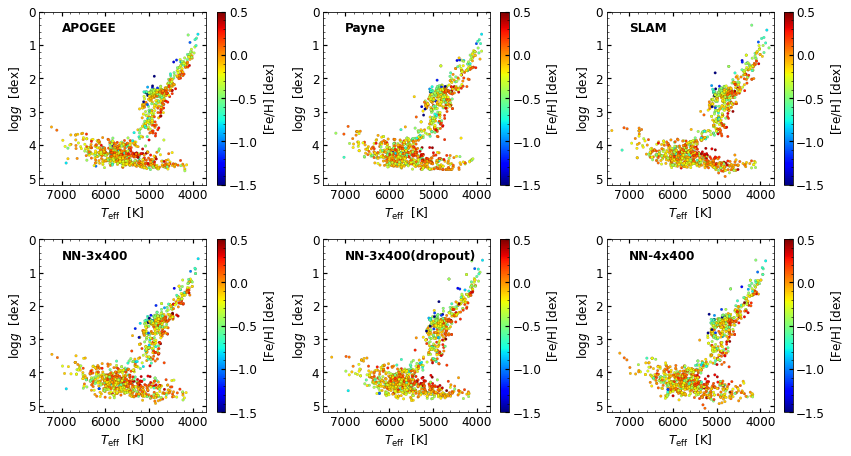

In [11]:
from laspec.mpl import set_cham
set_cham(12, latex=False)

# load saved labels
xpred_slam = joblib.load("sb2dc/slam_1k.dump")["Xpred"]
xpred_payne = joblib.load("sb2dc/payne_1k.dump")["ppay"]
xpred_torch3x400 = joblib.load("sb2dc/xpred_torch3x400_1k.dump")
xpred_torch3x400_dp = joblib.load("sb2dc/xpred_torch3x400_dp_1k.dump")
xpred_torch4x400 = joblib.load("sb2dc/xpred_torch4x400_1k.dump")

def plot_tgm(ax, tgm, title="",vmin=-1.5, vmax=.5):
    _ = ax.scatter(tgm[:,0], tgm[:,1], s=7, c=tgm[:,2], cmap=cm.jet,vmin=vmin, vmax=vmax, edgecolors="k",linewidths=.1)
    ax.set_xlim(7510, 3700)
    ax.set_ylim(5.2, 0)
    ax.text(7000, .5, title, ha="left", va="center", fontweight="bold")
    c = plt.colorbar(_, ax=ax)
    c.set_label("$\\mathrm{[Fe/H]}$ [dex]")
    ax.set_xlabel("$T_\\mathrm{eff}$  [K]")
    ax.set_ylabel("$\\log{g}$  [dex]")
    
fig, axs=plt.subplots(2,3, figsize=(12, 6.5))
plot_tgm(axs[0,0], data["pap"], "APOGEE")
plot_tgm(axs[0,1], xpred_payne, "Payne")
plot_tgm(axs[0,2], xpred_slam, "SLAM")
plot_tgm(axs[1,0], xpred_torch3x400, "NN-3x400")
plot_tgm(axs[1,1], xpred_torch3x400_dp, "NN-3x400(dropout)")
plot_tgm(axs[1,2], xpred_torch4x400, "NN-4x400")
fig.tight_layout()
fig.savefig("performance_slam_pytorch.pdf")
fig.savefig("performance_slam_pytorch.png")
